https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic  
https://medium.com/@asteinbach/actor-critic-using-deep-rl-continuous-mountain-car-in-tensorflow-4c1fb2110f7c

# Actor-Critic

In [1]:
%load_ext autoreload
%autoreload 2

import collections
import gym
import numpy as np
import tensorflow as tf
import tqdm
import time
import matplotlib.pyplot as plt

from a2c import *

## Playing with discrete actions

In [2]:
env = gym.make("CartPole-v0")
a2c = A2CDiscrete(env=env,
                  reward_type="int32")
model = ActorCriticModelDiscrete(num_actions=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

## Playing with continuous actions

In [3]:
env = gym.make('MountainCarContinuous-v0')
a2c = A2CContinuous(env,
                    reward_type="float32")
model = ActorCriticModelContinuous(num_actions=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Train the agent

In [3]:
# model = tf.keras.models.load_model("saved_models/a2c_model")

In [4]:
%%time

min_episodes_criterion = 10
max_episodes = 1000
max_steps_per_episode = 500

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
running_reward = 0
rewards = []

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
    for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        episode_reward = int(a2c.train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

        episodes_reward.append(episode_reward)
        running_reward = np.mean(episodes_reward)
        rewards.append(episode_reward)

        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 999: 100%|█████████████████████████| 1000/1000 [03:05<00:00,  5.38it/s, episode_reward=200, running_reward=200]


Solved at episode 999: average reward: 200.00!
Wall time: 3min 5s


In [5]:
# model.save("saved_models/a2c_model")

## Plot rewards

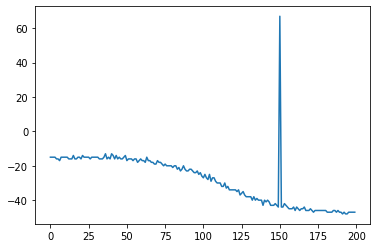

In [5]:
plt.plot(rewards);

## Use agent

In [7]:
screen = a2c.env.render(mode='rgb_array')

state = tf.constant(a2c.env.reset(), dtype=tf.float32)
initial_state_shape = state.shape

for i in range(max_steps_per_episode):
    state = tf.expand_dims(state, 0)
    
    if isinstance(a2c, A2CDiscrete):
        action_probs, _ = model(state)
        action = np.argmax(np.squeeze(action_probs))
    elif isinstance(a2c, A2CContinuous):
        _, norm_dist, _ = model(state)
        action = norm_dist.loc
    
    state, _, done, _ = a2c.env.step(action)
    state = tf.reshape(state, initial_state_shape)

    screen = a2c.env.render(mode='rgb_array')
    time.sleep(0.05)
    if done:
        break
